# Word Embeddings Analysis with GloVe 🔤

## TC 3007B - Activity 1

### Team Members

- [Carlos Salguero](https://github.com/salgue441)
- [Diego Perdomo](https://github.com/DiegoPerdomoS)
- [Luis Arturo](https://github.com/00sen)
- [José Riosmena](https://github.com/Riosmena)
- [Dafne](https://github.com/Dafne224)

## 📚 Overview

This notebook explores word embeddings using GloVe (Global Vectors for Word Representation) to understand semantic relationships between words. We'll implement various techniques to visualize and analyze the embeddings, such as t-SNE and PCA.

## Assignment Objectives ✅

1. Understanding word embeddings in NLP
2. Implementing dimensionality reduction (PCA and t-SNE) to visualize embeddings
3. Creating word similarity and analogy functions
4. Visualizing high-dimensional embeddings data


## 🛠️ Setup & Configuration

First, we'll import the necessary libraries and set up our configuration.


In [1]:
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

### Configuration Settings


In [2]:
plt.style.use("ggplot")
sns.set_palette("tab10")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Embedding Class


In [4]:
@dataclass
class EmbeddingConfig:
    path: Path
    dim: int = 50
    cache_path: Path = Path("cache")
    use_cache: bool = True
    case_sensitive: bool = False

    def __post_init__(self):
        self.cache_path.mkdir(exist_ok=True)

        if not self.path.exists():
            raise FileNotFoundError(f"Embedding file not found: {self.path}")

## Embedding Class

The following class handles:

- Loading and caching embeddings
- Word similarity calculations
- Analogy computations
- Visualization of embeddings


In [5]:
class Embeddings:
    """
    Embeddings class designed to load and work with word embeddings.

    Attributes:
        config (EmbeddingConfig): The configuration for the embeddings.
        embeddings (Dict[str, torch.Tensor]): The embeddings dictionary.
    """

    def __init__(self, config: Optional[EmbeddingConfig] = None):
        self.config = config
        self.embeddings: Dict[str, torch.Tensor] = {}

    def load_embedding(self):
        """
        Loads the embeddings from the file path specified in the config.

        Raises:
            FileNotFoundError: If the file is not found.
        """

        cache_file = self.config.cache_path / f"embeddings_{self.config.dim}d.pt"

        if self.config.use_cache and cache_file.exists():
            self.embeddings = torch.load(cache_file)
            return

        with open(self.config.path, "r", encoding="utf-8") as file:
            for line in tqdm(file, desc="Processing embeddings"):
                values = line.split()
                word = values[0]

                if not self.config.case_sensitive:
                    word = word.lower()

                try:
                    vector = torch.tensor(
                        [float(value) for value in values[1:]],
                        dtype=torch.float32,
                        device=device,
                    )

                    self.embeddings[word] = F.normalize(vector, p=2, dim=0)

                except Exception as e:
                    print(f"Error: {e}")

        if self.config.use_cache:
            torch.save(self.embeddings, cache_file)

    def get_embedding(self, word: str) -> Optional[torch.Tensor]:
        """
        Get the embedding for a word.

        Args:
            word (str): The word to get the embedding for.

        Returns:
            Optional[torch.Tensor]: The embedding for the word if it exists, else None.
        """
        word = word.lower() if not self.config.case_sensitive else word
        return self.embeddings.get(word)

    def find_most_similar(self, word: str, top_n: int = 10) -> List[Tuple[str, float]]:
        """
        Finds the most similar words to the given word based on cosine
        similarity.

        Args:
            word (str): The word to find similar words for.
            top_n (int, optional): The number of similar words to return. Defaults to 10.

        Returns:
            List[Tuple[str, float]]: The list of similar words and their cosine similarity.

        Raises:
            KeyError: If the word is not found in the embeddings.
        """

        word_embedding = self.get_embedding(word)
        if word_embedding is None:
            raise KeyError(f"Word not found in embeddings: {word}")

        words = list(self.embeddings.keys())
        embeddings = torch.stack(list(self.embeddings.values()))

        with torch.inference_mode():
            similarities = F.cosine_similarity(
                word_embedding.unsqueeze(0), embeddings, dim=1
            )

        top_similarities, top_indices = similarities.topk(top_n + 1)
        results = [
            (words[idx], sim.item())
            for idx, sim in zip(top_indices, top_similarities)
            if words[idx] != word
        ][:top_n]

        return results

    def compute_analogy(
        self, word1: str, word2: str, word3: str, top_n: int = 5
    ) -> List[Tuple[str, float]]:
        """
        Computes the analogy words for the given words. It finds the word
        based on the analogy: word2 - word1 + word3.

        Args:
            word1 (str): The first word.
            word2 (str): The second word.
            word3 (str): The third word.
            top_n (int, optional): The number of analogy words to return. Defaults to 5.

        Returns:
            List[Tuple[str, float]]: The list of analogy words and their cosine similarity.
        """

        embs = [self.get_embedding(word) for word in (word1, word2, word3)]
        if None in embs:
            missing = [w for w, e in zip([word1, word2, word3], embs) if e is None]

            raise KeyError(f"Word(s) not found in embeddings: {missing}")

        with torch.inference_mode():
            target = embs[1] - embs[0] + embs[2]
            target = F.normalize(target, p=2, dim=0)

            words = list(self.embeddings.keys())
            embeddings = torch.stack(list(self.embeddings.values()))
            similarities = F.cosine_similarity(target.unsqueeze(0), embeddings)

            top_similarities, top_indices = similarities.topk(top_n)
            results = [
                (words[idx], sim.item())
                for idx, sim in zip(top_indices, top_similarities)
                if words[idx] not in [word1, word2, word3]
            ][:top_n]

        return results

    def visualize_embeddings(
        self,
        words: List[str],
        method: str = "tsne",
        figsize: Tuple[int, int] = (10, 10),
    ):
        """
        Visualizes the generated embeddings in dimensionality
        reduction plots, default being TSNE.

        Args:
            words (List[str]): The words to visualize.
            method (str, optional): The dimensionality reduction method to use. Defaults to "tsne".
            figsize (Tuple[int, int], optional): The figure size. Defaults to (10, 10).

        Raises:
            ValueError: If no valid words are found in the embeddings.
        """

        valid_words, embedding_list = [], []
        for word in words:
            emb = self.get_embedding(word)

            if emb is not None:
                valid_words.append(word)
                embedding_list.append(emb.cpu())

            else:
                print(f"Warning: '{word}' not found in vocabulary")

        if not embedding_list:
            raise ValueError("No valid words found in embeddings")

        embeddings_array = np.stack(embedding_list)
        reducer = (
            TSNE(n_components=2, perplexity=min(30, len(valid_words) - 1))
            if method.lower() == "tsne"
            else PCA(n_components=2)
        )

        reduced = reducer.fit_transform(embeddings_array)
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            reduced[:, 0],
            reduced[:, 1],
            c=range(len(valid_words)),
            cmap="viridis",
            alpha=0.6,
        )

        for i, word in enumerate(valid_words):
            plt.annotate(
                word,
                (reduced[i, 0], reduced[i, 1]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=10,
                alpha=0.8,
            )

        plt.title(f"Word Embeddings ({method.upper()})")
        plt.colorbar(scatter, label="Word Index")
        plt.tight_layout()
        plt.show()

    def create_similarity_matrix(
        self, words: List[str], include_scores: bool = False
    ) -> Tuple[torch.Tensor, List[str]]:
        """
        Creates a similarity matrix for the given words.

        Args:
            words (List[str]): The words to create the similarity matrix for.
            include_scores (bool, optional): Whether to include the similarity scores in the matrix. Defaults to False.

        Returns:
            Tuple[torch.Tensor, List[str]]: The similarity matrix and the list of words.

        Raises:
            ValueError: If no valid words are found in the embeddings
        """
        valid_pairs = [(word, self.get_embedding(word)) for word in words]
        valid_words = [word for word, emb in valid_pairs if emb is not None]
        valid_embeddings = [emb for _, emb in valid_pairs if emb is not None]

        if not valid_embeddings:
            raise ValueError("No valid words found in embeddings")

        embeddings_tensor = torch.stack(valid_embeddings)
        with torch.inference_mode():
            embeddings_normalized = F.normalize(embeddings_tensor, p=2, dim=1)
            similarity_matrix = torch.mm(embeddings_normalized, embeddings_normalized.T)

        return similarity_matrix, valid_words

    def plot_similarity_matrix(
        self,
        words: List[str],
        figsize: Tuple[int, int] = (12, 10),
        cmap: str = "RdYlBu",
        annot: bool = True,
    ) -> None:
        """
        Create and plot a similarity matrix heatmap

        Args:
            words: List of words to compare
            figsize: Figure size
            cmap: Colormap to use
            annot: Whether to annotate cells with numerical value
        """
        similarity_matrix, valid_words = self.create_similarity_matrix(words)

        plt.figure(figsize=figsize)
        sns.heatmap(
            similarity_matrix.cpu().numpy(),
            xticklabels=valid_words,
            yticklabels=valid_words,
            cmap=cmap,
            annot=annot,
            fmt=".2f",
            square=True,
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={"label": "Cosine Similarity"},
        )

        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)

        plt.title("Word Similarity Matrix")
        plt.tight_layout()
        plt.show()

    def plot_similiratiy_dendogram(
        self,
        words: List[str],
        figsize: Tuple[int, int] = (15, 10),
        method: str = "ward",
        metric: str = "euclidean",
    ):
        """
        Create a dendogram based on the similarity matrix

        Args:
            words (List[str]): List of words to compare
            figsize (Tuple[int, int], optional): Figure size. Defaults to (15, 10).
            method (str, optional): The linkage method to use. Defaults to "ward".
            metric (str, optional): The distance metric to use. Defaults to "euclidean".
        """

        similarity_matrix, valid_words = self.create_similarity_matrix(words)
        distances = 1 - similarity_matrix.cpu().numpy()
        linkage_matrix = sch.linkage(distances, method=method, metric=metric)

        plt.figure(figsize=figsize)
        sch.dendrogram(
            linkage_matrix, labels=valid_words, leaf_rotation=90, leaf_font_size=10
        )

        plt.title("Word Similarity Dendogram")
        plt.xlabel("Words")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.show()

## Main Execution


In [6]:
config = EmbeddingConfig(path=Path("data/glove.6B.50d.txt"), dim=50)

In [7]:
embedding_manager = Embeddings(config)
embedding_manager.load_embedding()

/tmp/ipykernel_29578/2407720002.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.embeddings = torch.load(cache_file)


### Similary Matrix


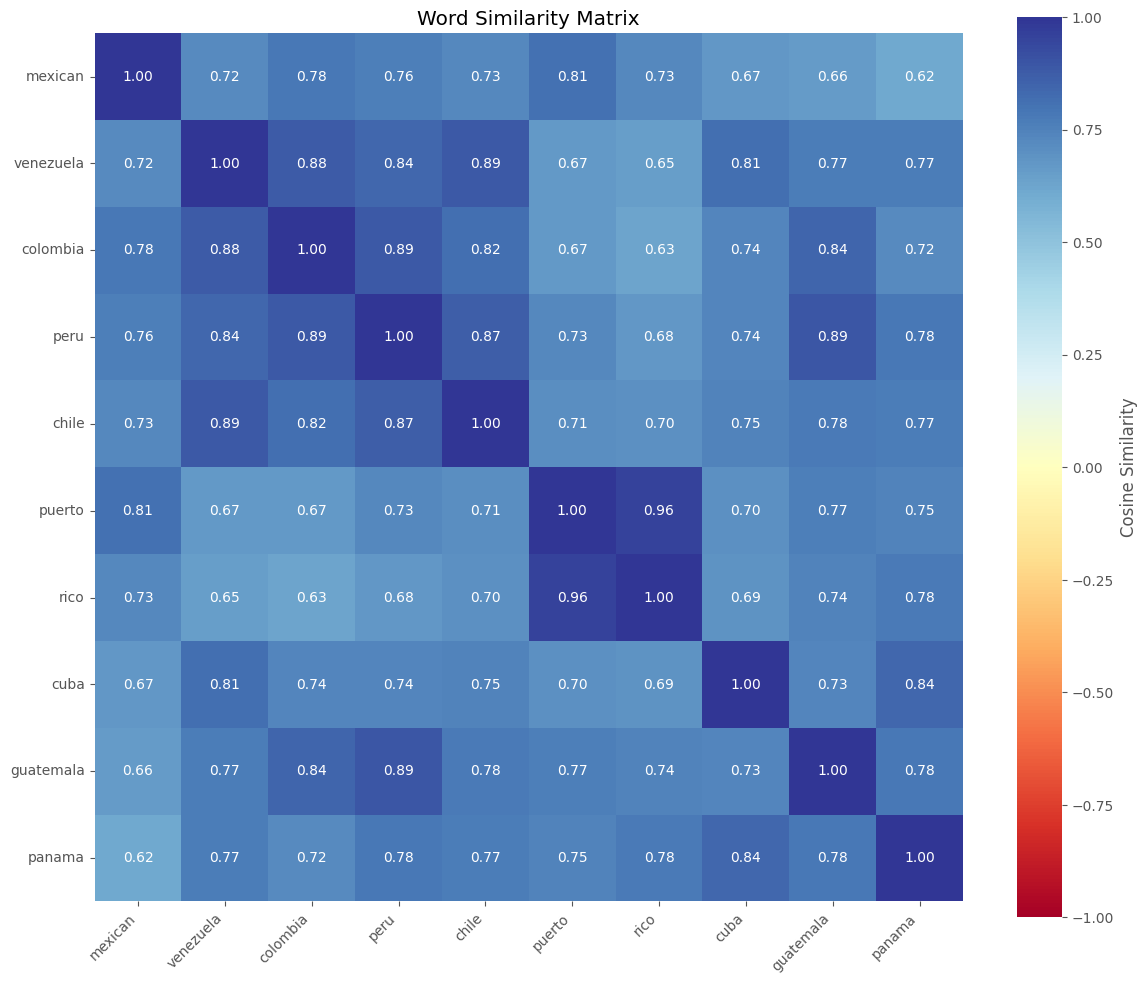

In [8]:
similar_words = embedding_manager.find_most_similar("mexico", top_n=10)
embedding_manager.plot_similarity_matrix([word for word, _ in similar_words])

- The diagonal values are 1.00, which is expected since each term is identical to itself.
- High similarity groups:
  - Venezuela, Colombia, and Peru: these terms have consistently high similarities (above 0.85) with one another, indicating they are semantically similar.
  - Puerto Rico and Cuba: these have high similarity (0.96), suggesting they are closely related.
- Low similiarity groups:
  - Panama and Mexico: these pair has a relatively lower similarity (0.62).
  - Guatemala and Puerto Rico: Similarity around 0.69.
- Outliers:
  - Guatemala and Panama seem to have a stronger connection to Peru and Colombia that to Mexico or Puerto Rico.
  - Puerto Rico and Cuba form a distinct group, possibly due to linguistic ties.


### Analogy Task


In [9]:
analogy_results = embedding_manager.compute_analogy("man", "king", "woman", top_n=5)

print("\nAnalogy results for 'man:king::woman:?':")
for i, (word, score) in enumerate(analogy_results, 1):
    print(f"{i}. {word}: {score:.4f}")


Analogy results for 'man:king::woman:?':
1. queen: 0.8524
2. throne: 0.7664
3. prince: 0.7592
4. daughter: 0.7474


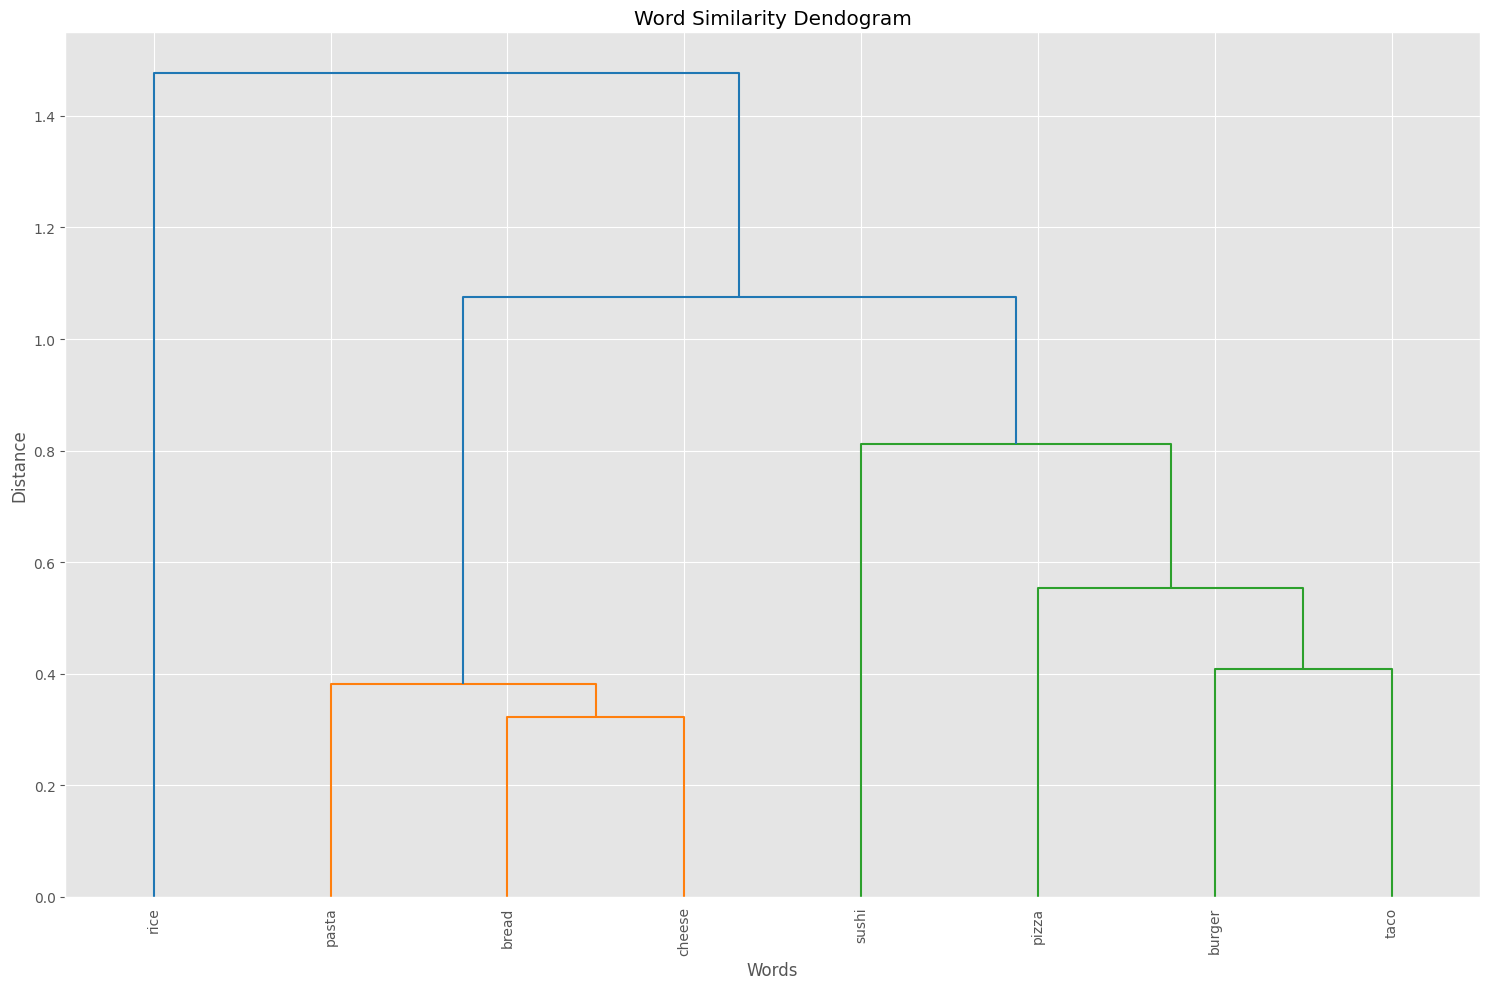

In [10]:
food_words = ["burger", "pizza", "pasta", "sushi", "taco", "rice", "bread", "cheese"]
embedding_manager.plot_similiratiy_dendogram(food_words)

- Clusters identified:
  - Rice forms its own distinct cluster at a high distance level.
  - Pasta, Bread, and Cheese are grouped together.
  - Sushi, Pizza, Burger, and Taco form another cluster.
- Subclusters:
  - Within the "prepared food" cluster (burger and taco) are closer together, indicating higher similarity.
  - Sushi and Pizza are also grouped but are slightly more distinct compared to Burger and Taco.
- Distance levels:
  - The y-axis represents the distance or dissimilarity between words. A higher distance value indicates lower similarity to other items.
  - Pasta, bread, and cheese are clustered at a fewer distance.


### 🔍 Dimensionality Reduction

Word relationship visualization in 2D space using t-SNE and PCA.


In [11]:
test_words = [
    "burger",
    "tortilla",
    "bread",
    "pizza",
    "beef",
    "steak",
    "fries",
    "chips",
    "argentina",
    "mexico",
    "spain",
    "usa",
    "france",
    "italy",
    "greece",
    "china",
    "water",
    "beer",
    "tequila",
    "wine",
    "whisky",
    "brandy",
    "vodka",
    "coffee",
    "tea",
    "apple",
    "banana",
    "orange",
    "lemon",
    "grapefruit",
    "grape",
    "strawberry",
    "raspberry",
    "school",
    "work",
    "university",
    "highschool",
]

#### t-SNE Visualization

t-SNE helps us visualize high-dimensional data by preserving local structure


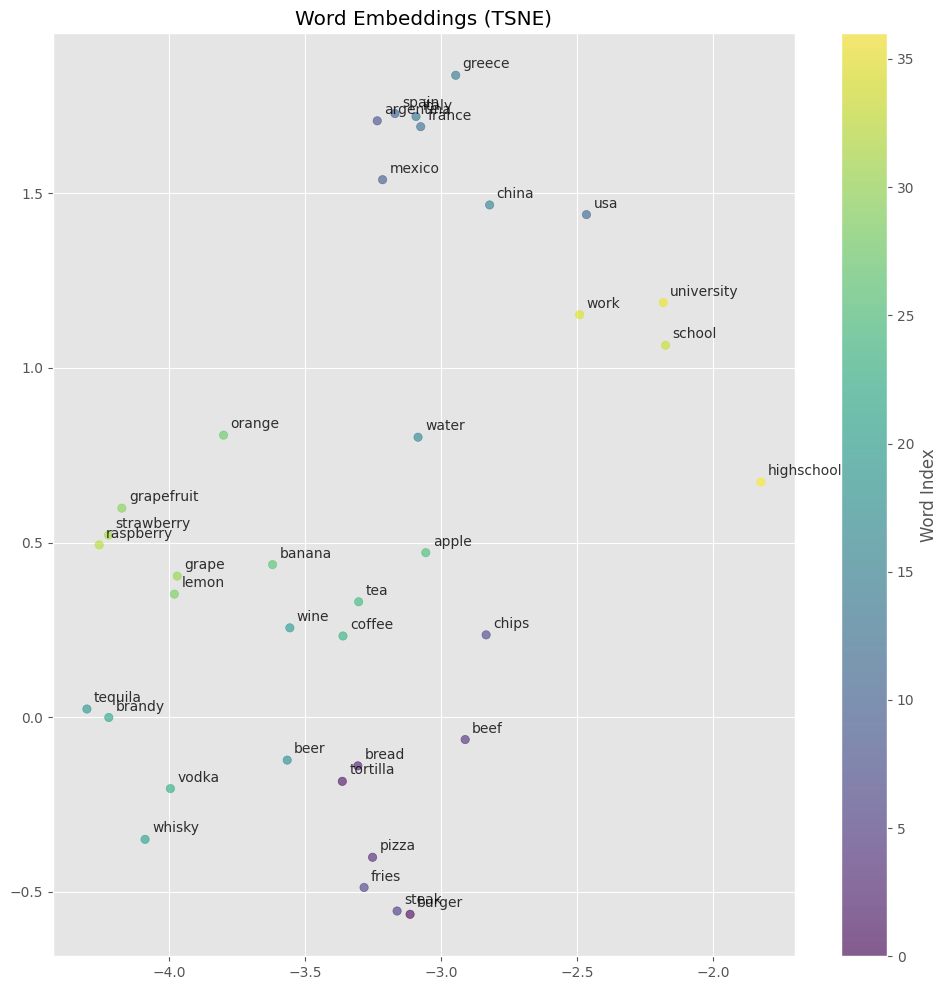

In [12]:
embedding_manager.visualize_embeddings(test_words, method="tsne")

### Cluster of Words

- Countries & Places
  - Words like italy, greece, france, mexico, and argentina form a tight cluster at the top-left, indicating semantic similarity.
  - china and usa are slightly isolated, possibly due to different contexts or usage in the corpus.
- Education & Work
  - Words such as work, university, school, and highschool form a cluster on the right, linked to education and professional environments. highschool appears slightly more distinct, possibly due to specific contexts tied to adolescence.
- Fruits & Drinks
  - Fruits: Words like orange, grapefruit, strawberry, lemon, and raspberry form a cluster. This reflects their similarity as fruits.
  - Drinks: Words such as coffee, tea, wine, and vodka form a group near the bottom center, likely due to their shared context as beverages.
  - Notably, water is more isolated, perhaps due to its more universal and less specific usage compared to alcoholic or caffeinated drinks.
- Fast food
  - Words like pizza, fries, burger, and steak cluster together. They are conceptually linked as common meal items or fast foods.
- Miscellaneous Food
  - chips, bread, and tortilla are nearby but slightly distinct, possibly reflecting their roles as complementary or side items.

### Gradient Legend (Word Index)

- The color gradient appears to represent the "word index".
- Words like highschool and work have higher indices, whereas words like whisky and raspberry have lower indices


### PCA


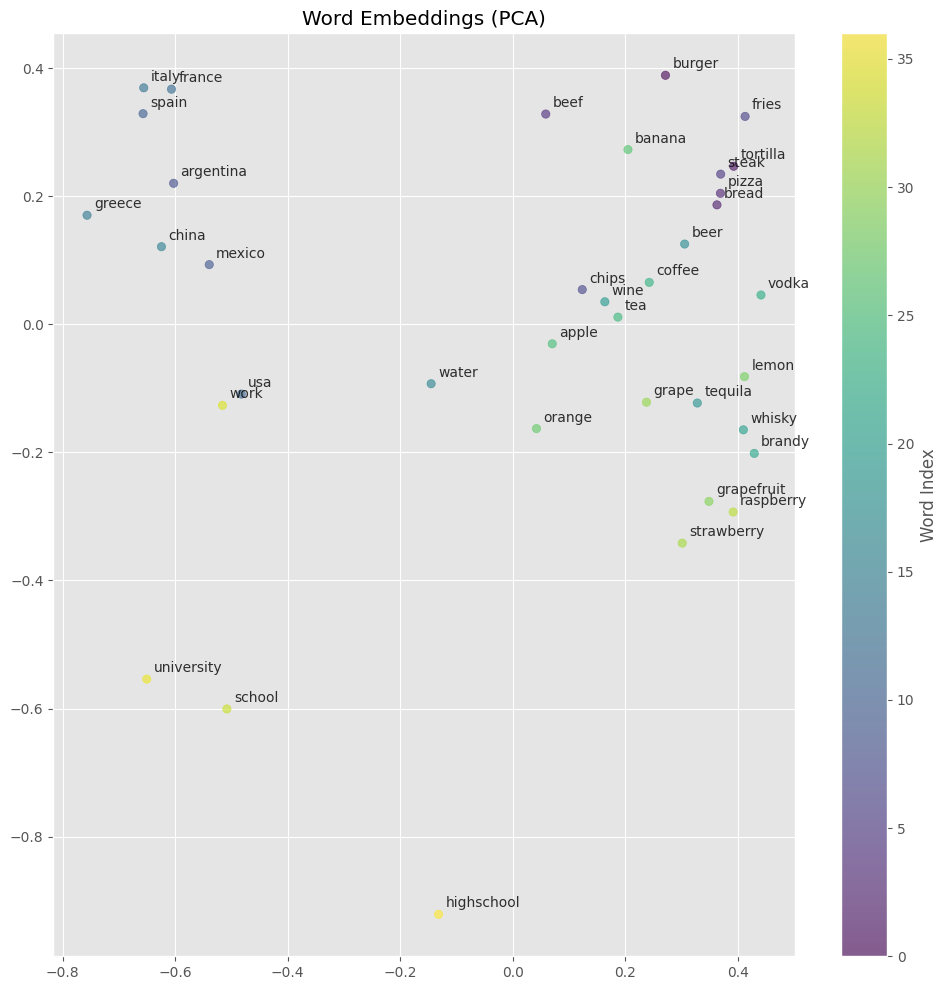

In [13]:
embedding_manager.visualize_embeddings(test_words, method="pca")

Shows similar clusters as t-SNE, but with some differences in the arrangement of words.

- Fruits like grapefruit, raspberry, and strawberry are clustered together.
- Beverages like brandy, whisky, tequila are grouped together. Addionally, near tequila we have words like grape, lemon, and orange.
- USA and work are close to each other, indicating a possible relationship between the two terms.
- Countries like France, Mexico, China, Argentina, Greece, Italy, and France are clustered together.
